In [2]:
from models import ToneLibrary, Tone
import matplotlib.pyplot as plt

tone_library = ToneLibrary(directory='Tones')
tone_library.populate()


/Users/p13i/Projects/hmm-tones/venv/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


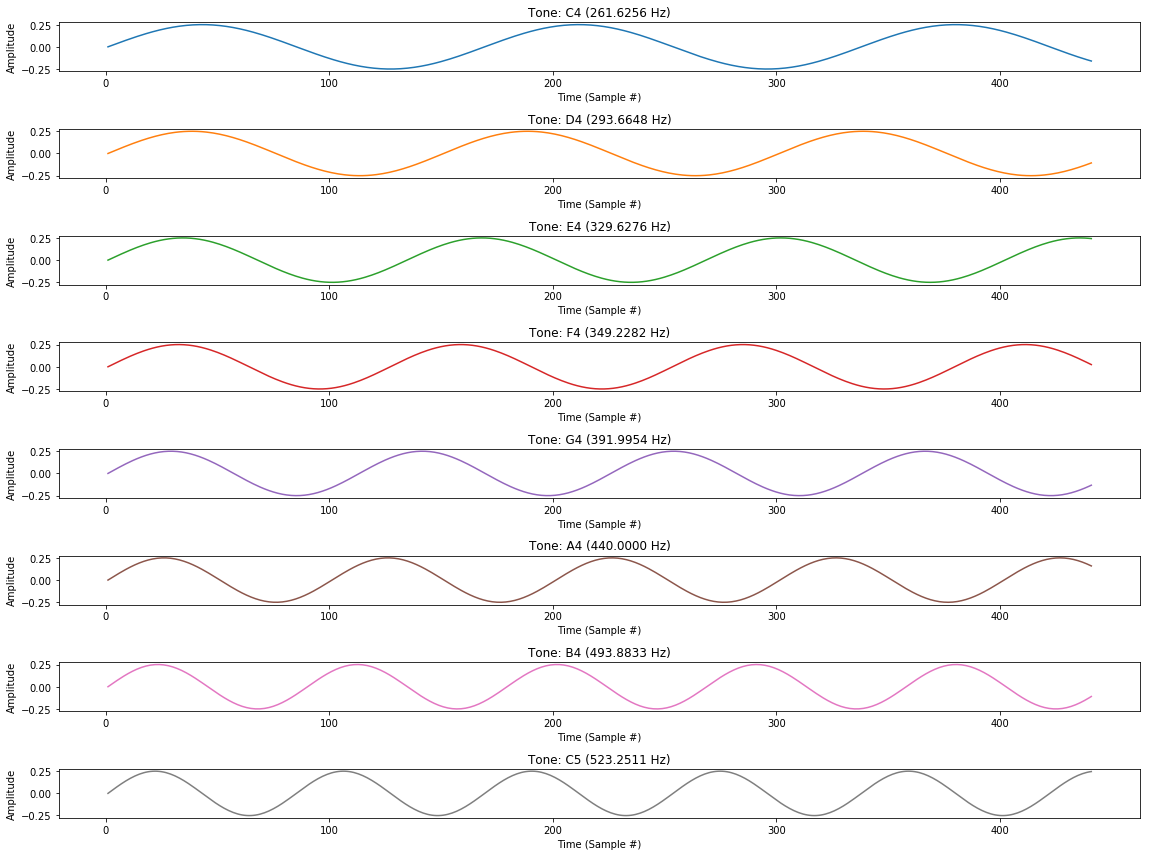

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

_, axes = plt.subplots(len(tone_library), 1, figsize=(16, 12))

# https://stackoverflow.com/a/42091037
plt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, tone in enumerate(tone_library):
    
    plt_num_samples = int(tone.num_total_samples / 50)
    x = tone.time[:plt_num_samples]
    y = tone.get_channel(1)[:plt_num_samples]
    
    ax = axes[i]
    sns.lineplot(x, y, color=plt_colors[i], ax=ax).set_title(str(tone))
    ax.set(xlabel='Time (Sample #)', ylabel='Amplitude')

plt.tight_layout()

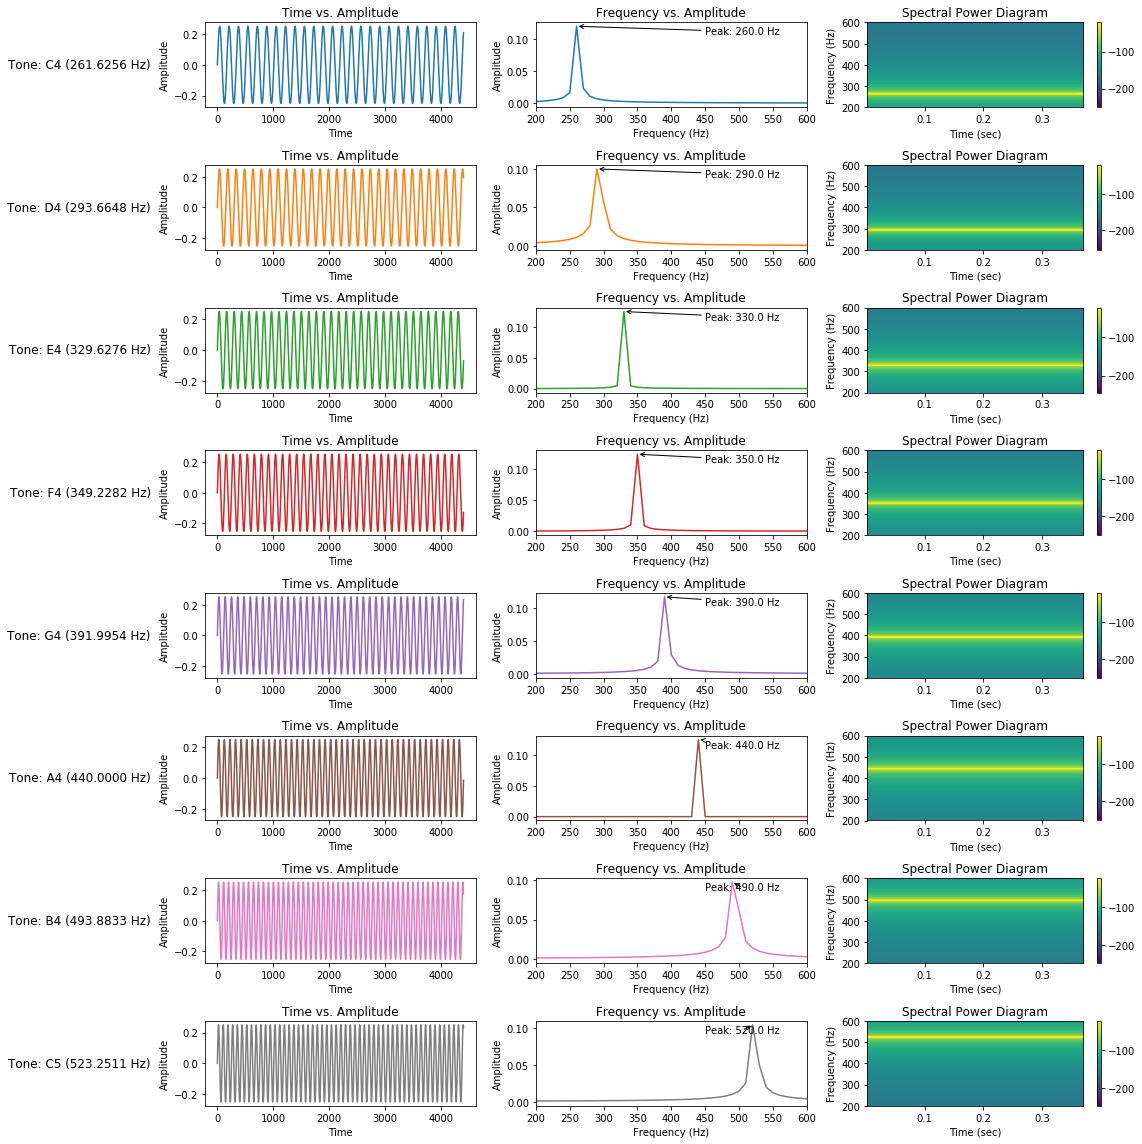

In [60]:
import numpy as np


def fft(signal, rate):
    """
    Based on https://plot.ly/matplotlib/fft/
    :param signal: 
    :param rate: 
    :return: 
    """
    n = len(signal)
    
    k = np.arange(n)
    T = n / rate
    freq = k / T  # two-sided frequency range
    freq = freq[range(int(n / 2))]  # one-sided frequency range
    
    # FFT + Normalization
    y = np.fft.fft(signal) / n
    y = y[range(int(n / 2))]
    y = abs(y)
    
    return freq, y


tones = list(tone_library)
fig, axes = plt.subplots(len(tones), 3, figsize=(16, 16))
freq_lim = (200, 600)

for i, tone in enumerate(tones):
        
    plt_num_samples = tone.num_total_samples // 5
    time = tone.time[:plt_num_samples]
    signal = tone.get_channel(1)[:plt_num_samples]
    rate = tone.rate
    
    fft_freq, fft_y = fft(signal, rate)
    
    max_fft_y_index = np.argmax(fft_y)
    max_fft_y_value = np.max(fft_y)
    estimated_peak_freq = fft_freq[max_fft_y_index]

    plt_color = plt_colors[i]
    
    ax = axes[i, 0]
    ax.annotate(str(tone), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
    ax = axes[i, 0]
    sns.lineplot(time, signal, linestyle='-', color=plt_color, ax=ax) \
        .set_title('Time vs. Amplitude')
    ax.set(xlabel='Time', ylabel='Amplitude')
    
    ax = axes[i, 1]
    sns.lineplot(fft_freq, fft_y, linestyle='-', color=plt_color, ax=ax) \
        .set_title('Frequency vs. Amplitude')
    ax.set(xlabel='Frequency (Hz)', ylabel='Amplitude', xlim=freq_lim)
    # https://matplotlib.org/gallery/text_labels_and_annotations/annotation_demo.html
    ax.annotate('Peak: %s Hz' % estimated_peak_freq,
                xy=(estimated_peak_freq, max_fft_y_value), xycoords='data',
                xytext=(0.9, 0.95), textcoords='axes fraction',
                arrowprops=dict(arrowstyle='->'),
                horizontalalignment='right', verticalalignment='top')

    ax = axes[i, 2]
    _, _, _, im = ax.specgram(tone.get_channel(1), NFFT=16386, Fs=tone.rate)
    ax.set_title('Spectral Power Diagram')
    ax.set(xlabel='Time (sec)', ylabel='Frequency (Hz)', ylim=freq_lim)
    fig.colorbar(im, ax=ax)

plt.tight_layout()

In [30]:
X_train = [[tone.frequency] for tone in tone_library]
y_train = [tone.scientific_name for tone in tone_library]

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Generate testing data
def sample_tone(tone, sample_ratio):
    num_samples = int(tone.num_total_samples * sample_ratio)
    return tone.time[:num_samples], tone.get_channel(1)[:num_samples]


def estimate_peak_freq(signal, rate):
    fft_freq, fft_y = fft(signal, rate)
    max_fft_y_index = np.argmax(fft_y)
    return fft_freq[max_fft_y_index]


X_test = []
y_test = []

for tone in tone_library:
    # Sample 20% of the tone
    t_sample, signal_sample = sample_tone(tone, 0.2)
    
    x = estimate_peak_freq(signal_sample, tone.rate)
    y = tone.scientific_name
    
    X_test.append([x])
    y_test.append(y)

y_predict = knn.predict(X_test)

import pandas as pd
results = pd.DataFrame({
    'Train: Scientific Name': y_train,
    'Train: Frequency (Hz)': [x[0] for x in X_train],
    'Test: Peak Frequency (Hz)': [x[0] for x in X_test],
    'Test: Estimated Scientific Name': y_predict,
    'Is Estimated Frequency Correct?': ['Yes' if prediction == label else 'No' for label, prediction in zip(y_train, y_predict)],
    'Train Frequency - Test Freqency': [train_freq - test_freq for train_freq, test_freq in zip([x[0] for x in X_train], [x[0] for x in X_test])]
})

from IPython.display import HTML
HTML(results.to_html(index=False))

Train: Scientific Name,Train: Frequency (Hz),Test: Peak Frequency (Hz),Test: Estimated Scientific Name,Is Estimated Frequency Correct?,|Train Frequency - Test Freqency|
C4,261.6256,260.0,C4,Yes,1.6256
D4,293.6648,290.0,D4,Yes,3.6648
E4,329.6276,330.0,E4,Yes,-0.3724
F4,349.2282,350.0,F4,Yes,-0.7718
G4,391.9954,390.0,G4,Yes,1.9954
A4,440.0000,440.0,A4,Yes,0.0000
B4,493.8833,490.0,B4,Yes,3.8833
C5,523.2511,520.0,C5,Yes,3.2511
